In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import kurtosis, skew
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import MSTL

from bluebikes_analysis.config import LOCAL_DATA_DIR
from bluebikes_analysis.plots import COLORS, plot_daily_longterm

In [2]:
def plot_single_time_series(data, title='', xlabel='', ylabel='', color=COLORS[2], figsize=(12, 6)):
    """
    Plot a single time series with consistent styling.
    
    Parameters:
    -----------
    data : pd.Series or pd.DataFrame column
        Time series data to plot (index should be datetime)
    title : str, optional
        Plot title (default: '')
    xlabel : str, optional
        X-axis label (default: '')
    ylabel : str, optional
        Y-axis label (default: '')
    color : str, optional
        Line color (hex code), default: colors[2] (orange)
    figsize : tuple, optional
        Figure size (width, height), default (12, 6)
    """
    plt.figure(figsize=figsize)
    plt.plot(data, marker="o", linestyle="-", color=color, markersize=2, linewidth=1)
    if title:
        plt.title(title, fontsize=14)
    if xlabel:
        plt.xlabel(xlabel, fontsize=11)
    if ylabel:
        plt.ylabel(ylabel, fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Reduce number of ticks
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=8))
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))
    
    plt.tight_layout()
    plt.show()

### Explore daily time series

In [3]:
# Get base folder and csv filenames
csv_folder = LOCAL_DATA_DIR / "interim/trip_aggregates"
csv_file = "daily_aggregates.csv"

df_daily = pd.read_csv(csv_folder / csv_file)

In [4]:
df_daily.head()

,date,trip_count
0,2018-05-01,5724
1,2018-05-02,6782
2,2018-05-03,5990
3,2018-05-04,5507
4,2018-05-05,5513


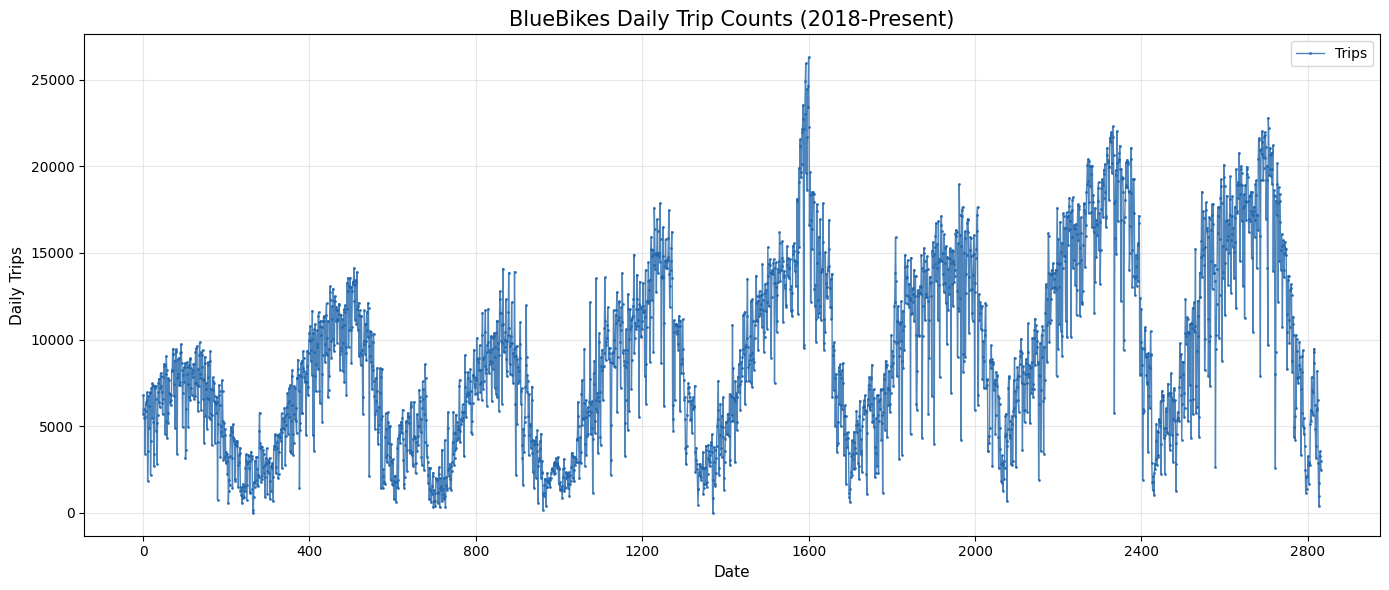

In [8]:
plot_daily_longterm(
    df_daily,
    columns_to_plot=["trip_count"],
    title=f"BlueBikes Daily Trip Counts (2018-Present)",
    xlabel="Date",
    ylabel="Daily Trips",
    color_list=[COLORS[7]],
    legend_labels=["Trips"],
    figsize=(14,6)
)

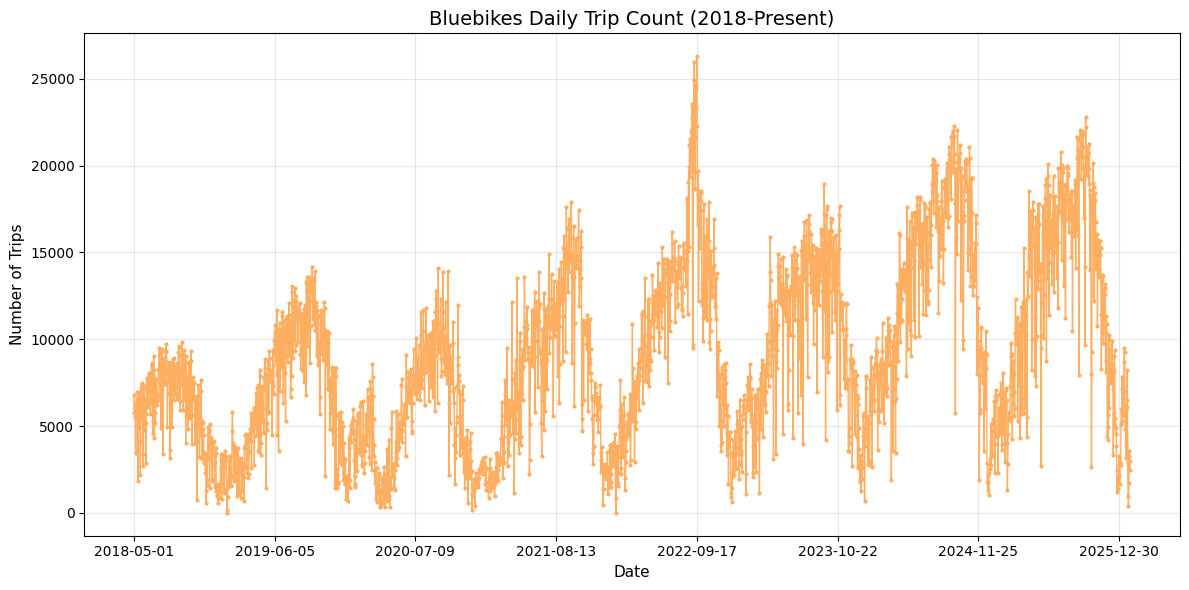

In [12]:
plot_single_time_series(
    data=df_daily.set_index('date')['trip_count'],
    title='Bluebikes Daily Trip Count (2018-Present)',
    xlabel='Date',
    ylabel='Number of Trips',
    color=COLORS[2]
)

We observe clear seasonality with consistent year-over-year growth in ridership. Notably, while summer peaks increase each year, winter troughs remain relatively flat around [X]k trips - suggesting Boston winters impose a consistent ridership floor regardless of system growth.

A striking anomaly appears in September 2019, reaching nearly 26k daily trips - roughly 50% above the prior year's maximum (17.5k) and 35% above 2020's peak (19k). This warrants investigation: special events, data quality issues, or operational changes during that period.

In [7]:
# Load trips from september 2022 to check the outlier
trips_csv_folder = LOCAL_DATA_DIR / "raw/trips"
df_trips_sep2021 = pd.read_csv(trips_csv_folder / "202109-bluebikes-tripdata.csv")
df_trips_sep2022 = pd.read_csv(trips_csv_folder / "202209-bluebikes-tripdata.csv")
df_trips_sep2023 = pd.read_csv(trips_csv_folder / "202309-bluebikes-tripdata.csv")

In [8]:
# Essential columns only
column_mapping = {
    # Timestamps
    "starttime": "started_at",
    "stoptime": "ended_at",
    # Station IDs (spatial aggregation)
    "start station id": "start_station_id",
    "end station id": "end_station_id",
    # Geographic infrastructure
    "start station latitude": "start_lat",
    "start station longitude": "start_lng",
    "end station latitude": "end_lat",
    "end station longitude": "end_lng",
    # User type (might be useful for segmentation)
    "usertype": "member_casual",
}

# Columns to keep (standardized names)
keep_columns = [
    "started_at",
    "ended_at",
    "start_station_id",
    "end_station_id",
    "start_lat",
    "start_lng",
    "end_lat",
    "end_lng",
    "member_casual",
    "rideable_type",  # Only in 2023+ data
]

# Homogenize column names
df_trips_sep2021 = df_trips_sep2021.rename(columns=column_mapping)
df_trips_sep2022 = df_trips_sep2022.rename(columns=column_mapping)
df_trips_sep2023 = df_trips_sep2023.rename(columns=column_mapping)

# Standardize member_casual values (old: Customer/Subscriber, new: casual/member)
member_mapping = {
    'Customer': 'casual',
    'Subscriber': 'member',
    'casual': 'casual',
    'member': 'member'
}

df_trips_sep2021['member_casual'] = df_trips_sep2021['member_casual'].map(member_mapping)
df_trips_sep2022['member_casual'] = df_trips_sep2022['member_casual'].map(member_mapping)
df_trips_sep2023['member_casual'] = df_trips_sep2023['member_casual'].map(member_mapping)

# Convert timestamps to datetime
for df in [df_trips_sep2021, df_trips_sep2022, df_trips_sep2023]:
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['trip_duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
    df['date'] = df['started_at'].dt.date

# Add year label for easy reference
df_trips_sep2021['year'] = 2021
df_trips_sep2022['year'] = 2022
df_trips_sep2023['year'] = 2023

print("=" * 60)
print("SEPTEMBER COMPARISON: 2021 vs 2022 vs 2023")
print("=" * 60)

# 1. Total trips per dataset
print("\n1. TOTAL TRIPS")
print(f"  September 2021: {len(df_trips_sep2021):,} trips")
print(f"  September 2022: {len(df_trips_sep2022):,} trips")
print(f"  September 2023: {len(df_trips_sep2023):,} trips")

# 2. Peak day analysis
print("\n2. PEAK DAY ANALYSIS")
for year, df in [(2021, df_trips_sep2021), (2022, df_trips_sep2022), (2023, df_trips_sep2023)]:
    daily_counts = df.groupby('date').size()
    peak_date = daily_counts.idxmax()
    peak_count = daily_counts.max()
    print(f"  {year}: {peak_date} with {peak_count:,} trips")

# 3. Trip duration statistics
print("\n3. TRIP DURATION (minutes)")
print("  Year    Median    Mean    90th percentile")
for year, df in [(2021, df_trips_sep2021), (2022, df_trips_sep2022), (2023, df_trips_sep2023)]:
    # Filter outliers (0-120 minutes for reasonable trips)
    valid_trips = df[(df['trip_duration_min'] > 0) & (df['trip_duration_min'] <= 120)]
    print(f"  {year}    {valid_trips['trip_duration_min'].median():.1f}      "
          f"{valid_trips['trip_duration_min'].mean():.1f}      "
          f"{valid_trips['trip_duration_min'].quantile(0.9):.1f}")

# 4. Unique bikes used (if bikeid exists in old data)
print("\n4. UNIQUE BIKES USED")
for year, df in [(2021, df_trips_sep2021), (2022, df_trips_sep2022), (2023, df_trips_sep2023)]:
    if 'bikeid' in df.columns:
        print(f"  {year}: {df['bikeid'].nunique():,} unique bikes")
    else:
        print(f"  {year}: bikeid not available (ride_id system)")

# 5. Member vs Casual split
print("\n5. MEMBER vs CASUAL RIDERSHIP")
print("  Year    Member %    Casual %")
for year, df in [(2021, df_trips_sep2021), (2022, df_trips_sep2022), (2023, df_trips_sep2023)]:
    member_pct = (df['member_casual'] == 'member').sum() / len(df) * 100
    casual_pct = (df['member_casual'] == 'casual').sum() / len(df) * 100
    print(f"  {year}    {member_pct:.1f}%      {casual_pct:.1f}%")

# 6. Rideable type distribution (2023 only)
print("\n6. RIDEABLE TYPE (2023 only)")
if 'rideable_type' in df_trips_sep2023.columns:
    rideable_counts = df_trips_sep2023['rideable_type'].value_counts()
    for rideable, count in rideable_counts.items():
        pct = count / len(df_trips_sep2023) * 100
        print(f"  {rideable}: {count:,} trips ({pct:.1f}%)")

# 7. Daily pattern visualization data
print("\n7. DAILY TRIP COUNTS")
for year, df in [(2021, df_trips_sep2021), (2022, df_trips_sep2022), (2023, df_trips_sep2023)]:
    daily_counts = df.groupby('date').size()
    print(f"  {year}: min={daily_counts.min():,}, max={daily_counts.max():,}, avg={daily_counts.mean():.0f}")

SEPTEMBER COMPARISON: 2021 vs 2022 vs 2023

1. TOTAL TRIPS
  September 2021: 432,254 trips
  September 2022: 601,049 trips
  September 2023: 419,874 trips

2. PEAK DAY ANALYSIS
  2021: 2021-09-25 with 18,178 trips
  2022: 2022-09-17 with 26,725 trips
  2023: 2023-09-14 with 19,279 trips

3. TRIP DURATION (minutes)
  Year    Median    Mean    90th percentile
  2021    11.9      16.3      31.8
  2022    12.1      16.1      31.5
  2023    12.0      15.8      30.1

4. UNIQUE BIKES USED
  2021: 3,560 unique bikes
  2022: 3,731 unique bikes
  2023: bikeid not available (ride_id system)

5. MEMBER vs CASUAL RIDERSHIP
  Year    Member %    Casual %
  2021    71.7%      28.3%
  2022    85.6%      14.4%
  2023    72.8%      27.2%

6. RIDEABLE TYPE (2023 only)
  docked_bike: 419,874 trips (100.0%)

7. DAILY TRIP COUNTS
  2021: min=8,681, max=18,178, avg=14408
  2022: min=9,624, max=26,725, avg=20035
  2023: min=4,292, max=19,279, avg=13996


In [9]:
# Extract peak days from each year
peak_date_2021 = pd.to_datetime('2021-09-25').date()
peak_date_2022 = pd.to_datetime('2022-09-17').date()
peak_date_2023 = pd.to_datetime('2023-09-14').date()

df_peak_2021 = df_trips_sep2021[df_trips_sep2021['date'] == peak_date_2021].copy()
df_peak_2022 = df_trips_sep2022[df_trips_sep2022['date'] == peak_date_2022].copy()
df_peak_2023 = df_trips_sep2023[df_trips_sep2023['date'] == peak_date_2023].copy()

print("=" * 60)
print("PEAK DAY DEEP DIVE")
print("=" * 60)

# 1. HOURLY DISTRIBUTION
print("\n1. HOURLY TRIP DISTRIBUTION")
print("  Hour   2021    2022    2023")
for hour in range(24):
    count_2021 = len(df_peak_2021[df_peak_2021['started_at'].dt.hour == hour])
    count_2022 = len(df_peak_2022[df_peak_2022['started_at'].dt.hour == hour])
    count_2023 = len(df_peak_2023[df_peak_2023['started_at'].dt.hour == hour])
    print(f"  {hour:02d}:00  {count_2021:5d}   {count_2022:5d}   {count_2023:5d}")

# 2. STATION CONCENTRATION ANALYSIS
print("\n2. STATION PICKUP CONCENTRATION")
print("  Metric                          2021      2022      2023")

for year, df_peak in [(2021, df_peak_2021), (2022, df_peak_2022), (2023, df_peak_2023)]:
    station_pickups = df_peak.groupby('start_station_id').size()
    print(f"\n  {year}:")
    print(f"    Unique stations:             {station_pickups.nunique():5d}")
    print(f"    Top station trips:           {station_pickups.max():5d}")
    print(f"    Top 5 stations % of total:   {station_pickups.nlargest(5).sum() / len(df_peak) * 100:5.1f}%")
    print(f"    Top 10 stations % of total:  {station_pickups.nlargest(10).sum() / len(df_peak) * 100:5.1f}%")
    print(f"    Median trips per station:    {station_pickups.median():5.1f}")

# 3. DUPLICATE TRIP DETECTION
print("\n3. POTENTIAL DUPLICATE TRIPS")
print("  Year    Exact duplicates    Similar trips (±1 min)")

for year, df_peak in [(2021, df_peak_2021), (2022, df_peak_2022), (2023, df_peak_2023)]:
    # Create trip signature: start station, end station, hour, rounded duration
    df_peak['trip_signature'] = (
        df_peak['start_station_id'].astype(str) + '_' +
        df_peak['end_station_id'].astype(str) + '_' +
        df_peak['started_at'].dt.hour.astype(str) + '_' +
        df_peak['trip_duration_min'].round(0).astype(str)
    )
    
    # Count duplicates
    signature_counts = df_peak['trip_signature'].value_counts()
    exact_duplicates = (signature_counts > 1).sum()
    trips_in_duplicates = signature_counts[signature_counts > 1].sum()
    
    print(f"  {year}    {exact_duplicates:6d} signatures    {trips_in_duplicates:6d} trips ({trips_in_duplicates/len(df_peak)*100:.1f}%)")

# 4. TOP DUPLICATE PATTERNS (for 2022)
print("\n4. TOP DUPLICATE PATTERNS (2022 only)")
print("  Count   Start Station   End Station   Hour   Duration")
df_peak_2022['trip_signature_detailed'] = (
    df_peak_2022['start_station_id'].astype(str) + '|' +
    df_peak_2022['end_station_id'].astype(str) + '|' +
    df_peak_2022['started_at'].dt.hour.astype(str) + '|' +
    df_peak_2022['trip_duration_min'].round(0).astype(str)
)
top_patterns = df_peak_2022['trip_signature_detailed'].value_counts().head(10)
for pattern, count in top_patterns.items():
    if count > 1:  # Only show actual duplicates
        parts = pattern.split('|')
        print(f"  {count:5d}   {parts[0]:15s} {parts[1]:15s} {parts[2]:5s}  {parts[3]:5s} min")

# 5. STATION DISTRIBUTION HISTOGRAM DATA
print("\n5. STATION PICKUP DISTRIBUTION (for plotting)")
for year, df_peak in [(2021, df_peak_2021), (2022, df_peak_2022), (2023, df_peak_2023)]:
    station_pickups = df_peak.groupby('start_station_id').size()
    print(f"\n  {year} - Trips per station quartiles:")
    print(f"    25th percentile: {station_pickups.quantile(0.25):.0f}")
    print(f"    50th percentile: {station_pickups.quantile(0.50):.0f}")
    print(f"    75th percentile: {station_pickups.quantile(0.75):.0f}")
    print(f"    95th percentile: {station_pickups.quantile(0.95):.0f}")

PEAK DAY DEEP DIVE

1. HOURLY TRIP DISTRIBUTION
  Hour   2021    2022    2023
  00:00    702     650      79
  01:00    637     493      47
  02:00    750     239      20
  03:00    687      91      18
  04:00    700      36      21
  05:00    572      49     114
  06:00    310     128     330
  07:00    116     258     998
  08:00     57     556    1696
  09:00     42     925     970
  10:00    116    1242     706
  11:00    199    1584     718
  12:00    365    1814     895
  13:00    669    1875     762
  14:00    818    2084     938
  15:00   1079    2307    1098
  16:00   1352    2166    1616
  17:00   1222    2159    2473
  18:00   1360    2189    2003
  19:00   1493    1745    1337
  20:00   1421    1314     851
  21:00   1294    1065     675
  22:00   1214     938     523
  23:00   1003     818     391

2. STATION PICKUP CONCENTRATION
  Metric                          2021      2022      2023

  2021:
    Unique stations:               128
    Top station trips:             434

**Eureka!**

The September 2022 peak wasn't a data anomaly—it was a transit crisis turned natural experiment. On September 17, 2022, Bluebikes recorded nearly 27,000 trips in a single day, driven by a perfect storm of factors:

1. **MBTA Orange Line Complete Shutdown** (Aug 19 - Sept 18): The city offered free Bluebikes memberships as alternative transit, more than doubling typical ridership during the 30-day closure.

2. **Major Events Convergence**: September 17 hosted the Boston Freedom Rally (~100k attendees), South Boston Street Festival, Beacon Hill HillFest, and other citywide events—all on the final weekend of free memberships.

3. **Policy Impact**: The 85.6% member ridership (vs typical 72%) reflects thousands of temporary free memberships issued during the shutdown, not a data error.

This spike represents bike share fulfilling its promise as resilient urban mobility infrastructure during transit disruptions.

**Sources:**
- [Bluebikes tweet announcing record](https://x.com/RideBluebikes/status/1571912468502384645)
- [Boston.com coverage of Orange Line shutdown impact](https://www.boston.com/news/local-news/2022/09/19/bluebikes-ridership-records-orange-line-shutdown/)
- [City of Boston events advisory](https://www.boston.gov/news/traffic-advisory-weekend-september-17-and-18-2022)
- [Free membership announcement (Reddit)](https://www.reddit.com/r/boston/comments/wvon5n/psa_free_blue_bikes_membership_during_mbta/)
- [Boston Freedom Rally coverage](https://thebostonsun.com/2022/09/29/masscann-sponsors-freedom-rally-on-common/)



---

## Time series analysis

## Variance Stabilization and Trend Estimation

### Addressing Heteroscedasticity

Preliminary inspection reveals that as the Bluebikes system grows, the **amplitude of fluctuations increases proportionally**—winter dips of 1,500 trips in 2018 become 3,000-trip dips by 2024. This **heteroscedasticity** (non-constant variance) suggests that seasonal effects operate **multiplicatively** rather than additively: a 30% winter reduction scales with system size.

To stabilize variance and satisfy modeling assumptions, we apply a **log transformation** before analysis. This converts multiplicative relationships to additive ones: percentage changes become constant differences in log-space, and the variance of residuals becomes homogeneous over time.

**Trade-off:** All subsequent analysis (trend coefficients, seasonal components, residuals) will be in log-scale, making absolute trip count interpretations less intuitive. However, since this notebook focuses on **understanding relative patterns, temporal structure, and the hierarchy of variance components**—not predicting exact trip counts—the log transformation is appropriate. We gain statistical validity (constant variance, proper residual diagnostics) in exchange for working in transformed units.

### Long-Term Trend Estimation

After log transformation, we observe steady growth in ridership—a classic example of **non-stationary data** where the mean is not constant. We fit a linear trend model in log-space using Ordinary Least Squares (OLS):

$$\log(Y_t) = \beta_0 + \beta_1 \cdot t + \varepsilon_t$$

where:
- $Y_t$ = daily trip count at time $t$
- $t$ = days elapsed since the start of the series
- $\beta_0$ = intercept (log of baseline ridership)
- $\beta_1$ = slope (daily percentage growth rate)
- $\varepsilon_t$ = residual error (now with stabilized variance)

**Interpretation:** In log-space, this represents linear growth. In the original scale, this corresponds to **exponential growth**: $Y_t \approx e^{\beta_0} \cdot e^{\beta_1 \cdot t}$, where $\beta_1$ represents the continuous compound growth rate. A fitted trend line in log-space becomes an exponential curve when back-transformed, revealing the system's multiplicative expansion. The residuals (log-actual minus log-fitted) capture deviations from this exponential trajectory and will help us isolate seasonal and irregular components.

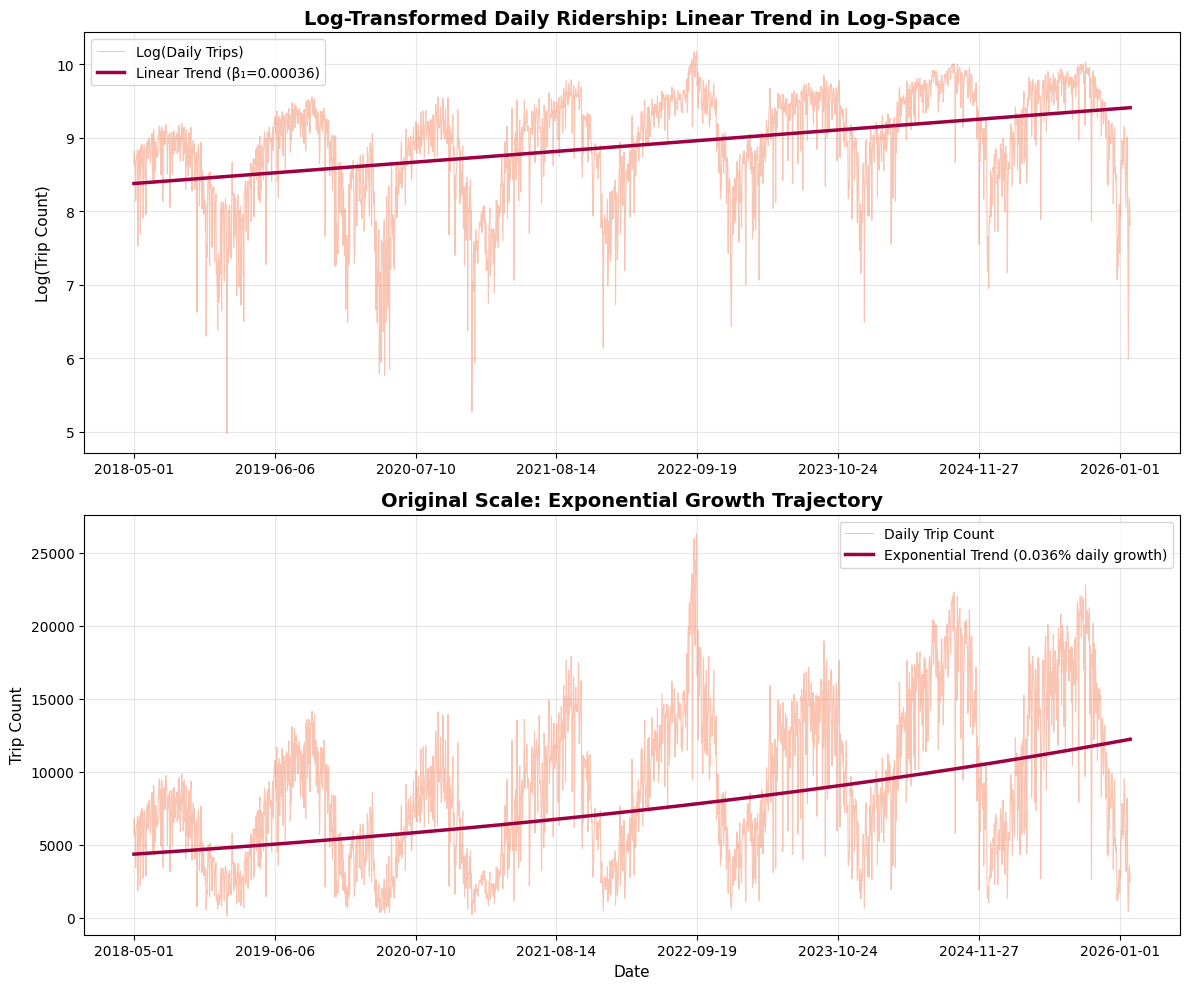


LOG-LINEAR TREND MODEL SUMMARY
Equation (log-space): log(trip_count) = 8.3789 + 0.000365 × t
Equation (original): trip_count ≈ 4354.38 × exp(0.000365 × t)
Daily growth rate: 0.036%
Annual growth rate: 14.2%
R-squared: 0.1639


In [32]:
# === LOG TRANSFORMATION (for variance stabilization) ===
df_daily_indexed['log_trip_count'] = np.log(df_daily_indexed['trip_count'])

# === TREND ESTIMATION (on log scale) ===
df_daily_indexed['time_index'] = np.arange(len(df_daily_indexed))

y = df_daily_indexed['log_trip_count']
X = sm.add_constant(df_daily_indexed['time_index'])

trend_model = sm.OLS(y, X).fit()
df_daily_indexed['log_trend_fit'] = trend_model.predict(X)
df_daily_indexed['log_residuals'] = trend_model.resid

# Extract parameters
beta_0, beta_1 = trend_model.params

# For interpretation, convert back to original scale
growth_rate_pct = (np.exp(beta_1) - 1) * 100  # daily % growth

# Visualize (can show both log-space and original space)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Log-space view
ax1.plot(df_daily_indexed.index, df_daily_indexed['log_trip_count'], 
         color=colors[2], alpha=0.4, linewidth=0.8, label='Log(Daily Trips)')
ax1.plot(df_daily_indexed.index, df_daily_indexed['log_trend_fit'], 
         color=colors[0], linewidth=2.5, label=f'Linear Trend (β₁={beta_1:.5f})')
ax1.set_title('Log-Transformed Daily Ridership: Linear Trend in Log-Space', 
              fontsize=14, fontweight='bold')
ax1.set_ylabel('Log(Trip Count)', fontsize=11)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Original-space view (exponential trend)
ax2.plot(df_daily_indexed.index, df_daily_indexed['trip_count'], 
         color=colors[2], alpha=0.4, linewidth=0.8, label='Daily Trip Count')
ax2.plot(df_daily_indexed.index, np.exp(df_daily_indexed['log_trend_fit']), 
         color=colors[0], linewidth=2.5, 
         label=f'Exponential Trend ({growth_rate_pct:.3f}% daily growth)')
ax2.set_title('Original Scale: Exponential Growth Trajectory', 
              fontsize=14, fontweight='bold')
ax2.set_ylabel('Trip Count', fontsize=11)
ax2.set_xlabel('Date', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=8))
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

# Model summary
print(f"\n{'='*60}")
print("LOG-LINEAR TREND MODEL SUMMARY")
print(f"{'='*60}")
print(f"Equation (log-space): log(trip_count) = {beta_0:.4f} + {beta_1:.6f} × t")
print(f"Equation (original): trip_count ≈ {np.exp(beta_0):.2f} × exp({beta_1:.6f} × t)")
print(f"Daily growth rate: {growth_rate_pct:.3f}%")
print(f"Annual growth rate: {(np.exp(365*beta_1)-1)*100:.1f}%")
print(f"R-squared: {trend_model.rsquared:.4f}")

### Model Results

The log-linear trend model reveals systematic exponential growth in Bluebikes ridership:

- **Growth rate**: 0.036% per day, compounding to approximately **14.2% annual growth** (highly significant, p < 0.001)
- **Baseline**: Starting from approximately 4,354 daily trips in log-space baseline (exp(8.38))
- **Model fit**: R² = 0.164, indicating the exponential trend explains ~16% of total variance in log-transformed data

The modest R² confirms what we see visually: **strong seasonal patterns dominate the signal**. The remaining 84% of variance reflects seasonal cycles (weekly and annual), weather effects, and operational events like the 2022 Orange Line shutdown. This motivates decomposition techniques to separate trend, seasonality, and irregular components.

**Note on variance stabilization:** The log transformation successfully addresses heteroscedasticity—residuals now exhibit constant variance over time rather than growing with system size. This validates our modeling assumptions and enables proper statistical inference. The trade-off is that R² and residual magnitudes are now in log-space, where a 1-unit deviation represents an order-of-magnitude difference in original trip counts. For our exploratory purposes—understanding temporal structure rather than predicting exact counts—this trade-off is acceptable.

The strong autocorrelation in log-residuals (visible in upcoming ACF analysis) confirms that simple exponential regression cannot capture the complex temporal dependencies. We need decomposition and frequency-domain methods to isolate the nested periodic patterns.

### Residual Analysis and Temporal Dependencies

We've quantified the long-term growth trend, but the modest R² (0.228) tells us the story is far from complete. The residuals—what remains after removing the linear trend—contain the "memory" and "rhythm" of urban mobility patterns.

Unlike pure random noise, bike-share demand exhibits systematic patterns: weekday commuter cycles, seasonal weather effects, and operational disruptions. Let's examine these residuals to understand what the simple linear model missed.

In [33]:
# Calculate and store residuals
df_daily_indexed['residuals'] = trend_model.resid

# Descriptive statistics
print("="*60)
print("RESIDUAL STATISTICS")
print("="*60)
print(df_daily_indexed['residuals'].describe())
print(f"\nMean: {df_daily_indexed['residuals'].mean():.2f} (should be ~0)")
print(f"Std Dev: {df_daily_indexed['residuals'].std():.2f}")

RESIDUAL STATISTICS
count    2.831000e+03
mean    -6.023676e-17
std      6.733079e-01
min     -3.498489e+00
25%     -3.659291e-01
50%      1.898161e-01
75%      5.086326e-01
max      1.215683e+00
Name: residuals, dtype: float64

Mean: -0.00 (should be ~0)
Std Dev: 0.67


### Visualizing the Residuals

The residuals reveal what the linear trend couldn't capture: seasonal cycles, day-of-week patterns, and special events.

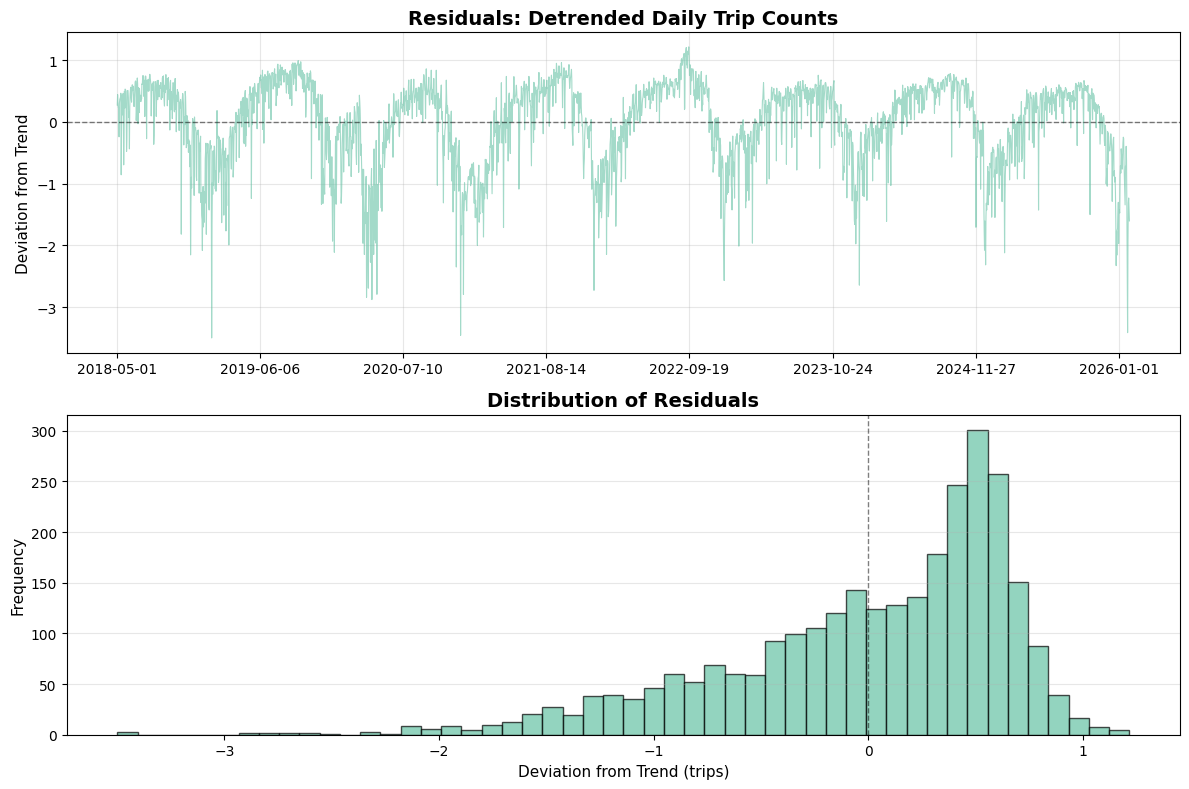

In [34]:
# Plot residuals over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Time series of residuals
ax1.plot(df_daily_indexed.index, df_daily_indexed['residuals'], 
         color=colors[8], linewidth=0.8, alpha=0.6)
ax1.axhline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_title('Residuals: Detrended Daily Trip Counts', fontsize=14, fontweight='bold')
ax1.set_ylabel('Deviation from Trend', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_locator(plt.MaxNLocator(nbins=8))
ax1.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))

# Histogram of residuals
ax2.hist(df_daily_indexed['residuals'], bins=50, color=colors[8], 
         edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
ax2.set_xlabel('Deviation from Trend (trips)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

**Residual distribution note:** The log-residuals exhibit mild left skewness (heavier tail toward negative values), indicating that **extreme under-performance days** (severe weather, holidays, operational disruptions) occur more frequently and severely than extreme over-performance days. This asymmetry is operationally meaningful—ridership has a practical floor (weather/holidays can shut the system down) but less potential for extreme positive deviations. For our exploratory analysis, this non-normality doesn't invalidate the trend estimation, though it suggests forecast prediction intervals should account for asymmetric risks.

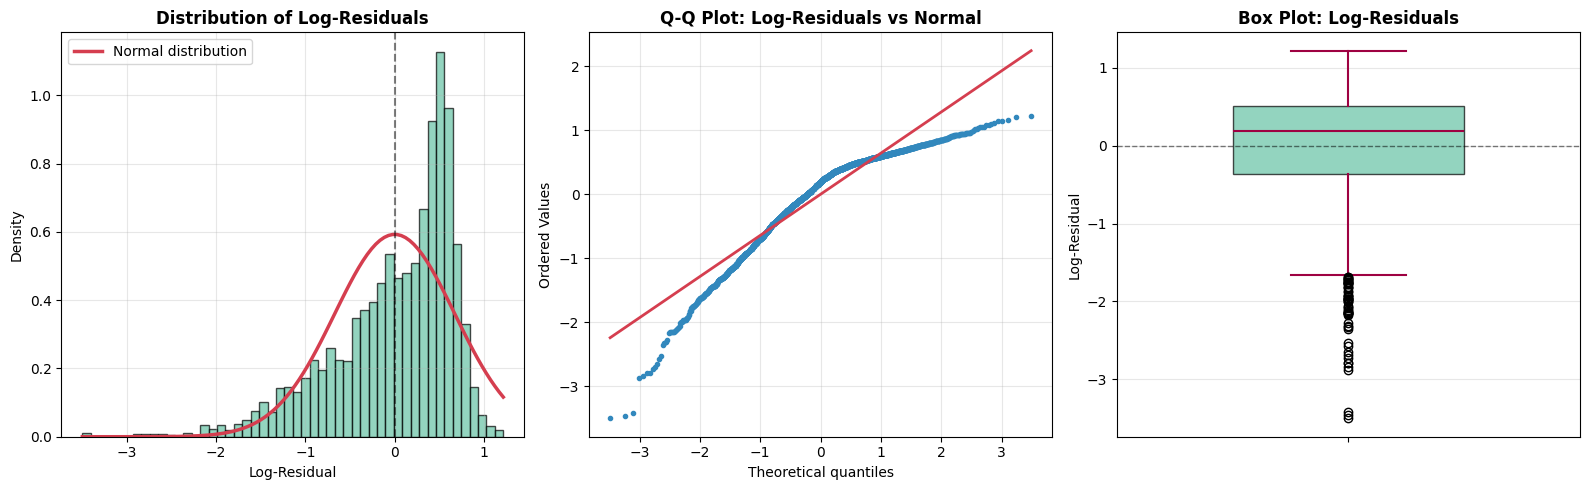

RESIDUAL DISTRIBUTION DIAGNOSTICS
Mean: -0.0000 (should be ~0)
Std Dev: 0.6733
Skewness: -1.1723 (0 = symmetric, <0 = left-skewed, >0 = right-skewed)
Kurtosis: 1.4562 (0 = normal, >0 = heavy tails, <0 = light tails)

Interpretation:
  Strong left skew detected - extreme under-performance days more common

EXTREME UNDER-PERFORMANCE DAYS (Bottom 1%)
            trip_count  log_residuals
date                                 
2019-01-21         145      -3.498489
2020-12-17         195      -3.456066
2026-01-26         402      -3.412811
2020-04-13         318      -2.876565
2020-03-29         328      -2.840132
2020-12-25         379      -2.794447
2020-04-27         348      -2.791520
2021-12-25         463      -2.727378
2020-04-03         381      -2.692170
2024-01-07         660      -2.643486


In [ ]:
# Visualize residual distribution and check for normality
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Histogram with normal overlay
ax1 = axes[0]
n, bins, patches = ax1.hist(df_daily_indexed['log_residuals'], bins=50, 
                             color=colors[8], edgecolor='black', alpha=0.7, density=True)

# Overlay normal distribution for comparison
mu, sigma = df_daily_indexed['log_residuals'].mean(), df_daily_indexed['log_residuals'].std()
x = np.linspace(df_daily_indexed['log_residuals'].min(), df_daily_indexed['log_residuals'].max(), 100)
ax1.plot(x, stats.norm.pdf(x, mu, sigma), color=colors[1], linewidth=2.5, 
         label='Normal distribution')
ax1.axvline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_title('Distribution of Log-Residuals', fontsize=12, fontweight='bold')
ax1.set_xlabel('Log-Residual', fontsize=10)
ax1.set_ylabel('Density', fontsize=10)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Q-Q plot (quantile-quantile)
ax2 = axes[1]
stats.probplot(df_daily_indexed['log_residuals'].dropna(), dist="norm", plot=ax2)
ax2.get_lines()[0].set_color(colors[9])
ax2.get_lines()[0].set_markersize(3)
ax2.get_lines()[1].set_color(colors[1])
ax2.get_lines()[1].set_linewidth(2)
ax2.set_title('Q-Q Plot: Log-Residuals vs Normal', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Box plot to show skewness
ax3 = axes[2]
bp = ax3.boxplot(df_daily_indexed['log_residuals'].dropna(), vert=True, patch_artist=True,
                 widths=0.5)
bp['boxes'][0].set_facecolor(colors[8])
bp['boxes'][0].set_alpha(0.7)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color=colors[0], linewidth=1.5)
ax3.axhline(0, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax3.set_title('Box Plot: Log-Residuals', fontsize=12, fontweight='bold')
ax3.set_ylabel('Log-Residual', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticklabels([''])

plt.tight_layout()
plt.show()

# Calculate skewness and kurtosis
skewness = skew(df_daily_indexed['log_residuals'].dropna())
kurt = kurtosis(df_daily_indexed['log_residuals'].dropna())

print("="*60)
print("RESIDUAL DISTRIBUTION DIAGNOSTICS")
print("="*60)
print(f"Mean: {mu:.4f} (should be ~0)")
print(f"Std Dev: {sigma:.4f}")
print(f"Skewness: {skewness:.4f} (0 = symmetric, <0 = left-skewed, >0 = right-skewed)")
print(f"Kurtosis: {kurt:.4f} (0 = normal, >0 = heavy tails, <0 = light tails)")
print("\nInterpretation:")
if skewness < -0.5:
    print("  Strong left skew detected - extreme under-performance days more common")
elif skewness < -0.2:
    print("  Moderate left skew - some asymmetry toward negative residuals")
else:
    print("  Distribution approximately symmetric")

# Identify extreme outliers
print("\n" + "="*60)
print("EXTREME UNDER-PERFORMANCE DAYS (Bottom 1%)")
print("="*60)
threshold = df_daily_indexed['log_residuals'].quantile(0.01)
extreme_low = df_daily_indexed[df_daily_indexed['log_residuals'] < threshold].copy()
extreme_low['trip_count'] = df_daily_indexed.loc[extreme_low.index, 'trip_count']
extreme_low = extreme_low.sort_values('log_residuals')
print(extreme_low[['trip_count', 'log_residuals']].head(10))

### Residual Distribution Analysis

The distribution of log-residuals reveals important asymmetries in how Bluebikes ridership deviates from its exponential growth trajectory:

**Distribution diagnostics:**
- **Skewness = -1.17**: Strong left skew—the distribution has a long tail extending toward negative values
- **Kurtosis = 1.46**: Heavier tails than a normal distribution (more extreme values than expected)
- **Mean ≈ 0**: Confirms unbiased trend estimation
- **Q-Q plot**: Systematic deviation in the left tail shows extreme under-performance days don't follow normal distribution

**What this reveals operationally:**

The left skew indicates that **extreme under-performance is more common and severe than extreme over-performance**. Examining the bottom 1% of residuals confirms this pattern—these days represent:

1. **Severe weather events**: January 2019, 2024, 2026 snowstorms shut down or severely limited service
2. **Major holidays**: December 25 (Christmas) in 2020, 2021—system usage collapses
3. **COVID-19 pandemic**: March-April 2020 shows the steepest under-performance as lockdowns eliminated commuting

**Operational interpretation:** Ridership has a **practical floor** (severe disruptions can reduce trips to near-zero) but less potential for extreme positive deviations. You can't have "twice the normal ridership" on a typical day, but a blizzard can eliminate 90% of trips. This asymmetry suggests:

- Forecast prediction intervals should be asymmetric (wider on the downside)
- Risk management should focus on operational resilience during disruptions
- The exponential trend captures "normal conditions" growth, but extreme events create systematic negative shocks

**For our analysis:** This non-normality doesn't invalidate the trend estimation (OLS coefficient estimates remain unbiased), though it suggests the residuals contain structured information beyond white noise—specifically, identifiable disruption events that could be modeled explicitly (holidays, weather thresholds, transit outages) in forecasting applications.

#### NOTE: On the normality-variance trade-off

Log transformation successfully stabilizes variance (critical for valid time series modeling) but introduces left skewness in residuals due to asymmetric operational shocks—severe disruptions (storms, holidays, COVID) can suppress ridership to near-zero, while positive deviations are bounded. Alternative approaches include:

1. **Box-Cox transformation**: Could optimize the power transformation, but likely won't eliminate asymmetry from genuinely asymmetric events
2. **Robust regression methods**: Accommodate non-normality without transformation
3. **Explicit event modeling**: Add dummy variables for known disruptions (holidays, weather, COVID)—likely the most principled approach for forecasting

For our exploratory analysis, we prioritize **variance stabilization** (essential for ACF/decomposition validity) and accept mild non-normality, recognizing that the skewness itself provides operational insight into asymmetric risk. Forecasting applications (Notebook 3) can address extreme events through exogenous regressors or robust methods.

---

**Observation**: The residuals don't behave like white noise. Notice the clear clustering—extended periods above and below the zero line. This "persistence" suggests strong **autocorrelation**: knowing yesterday's residual tells us something about today's.

This violates the independence assumption of our linear model. In bike-share systems, this makes intuitive sense:
- **Weekly cycles**: Weekday commuting vs weekend leisure
- **Seasonal persistence**: Long stretches of winter lows and summer highs
- **Weather clustering**: Multi-day cold snaps or heat waves

Let's apply smoothing techniques to reveal these underlying patterns.

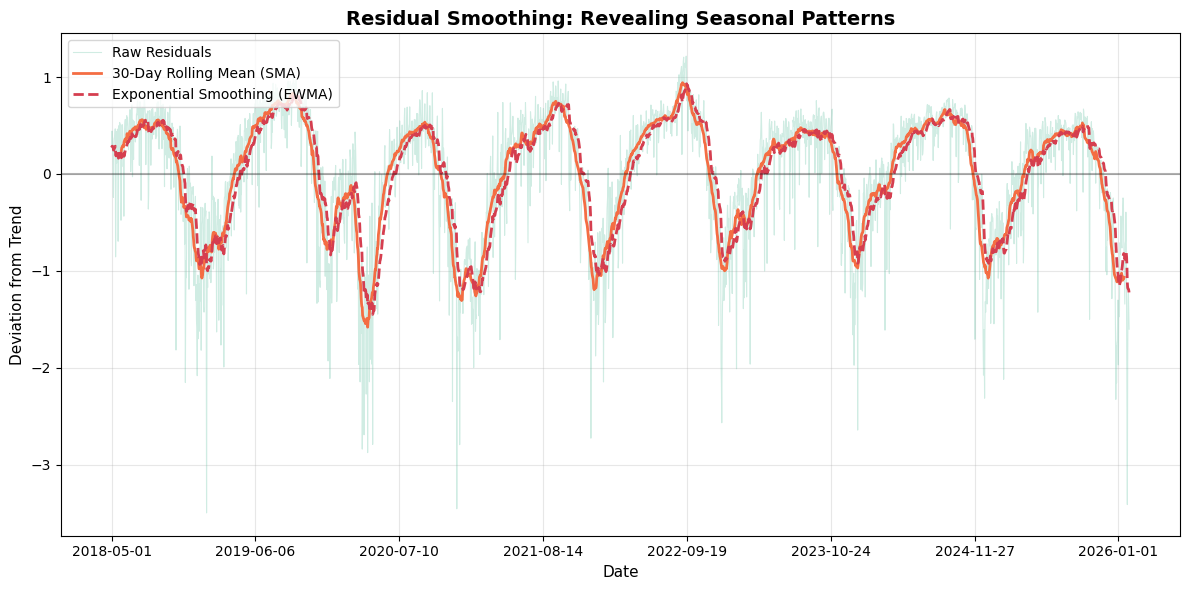

In [36]:
# Apply smoothing methods
# 30-day rolling mean (captures monthly patterns)
df_daily_indexed['sma_30'] = df_daily_indexed['residuals'].rolling(
    window=30, center=True).mean()

# Exponentially weighted moving average (recent days weighted more)
df_daily_indexed['ewma_30'] = df_daily_indexed['residuals'].ewm(
    span=30, adjust=False).mean()

# Visualization
plt.figure(figsize=(12, 6))

plt.plot(df_daily_indexed.index, df_daily_indexed['residuals'],
         color=colors[8], linewidth=0.8, alpha=0.3, label='Raw Residuals')
plt.plot(df_daily_indexed.index, df_daily_indexed['sma_30'],
         color=colors[2], linewidth=2, label='30-Day Rolling Mean (SMA)')
plt.plot(df_daily_indexed.index, df_daily_indexed['ewma_30'],
         color=colors[1], linewidth=2, linestyle='--', label='Exponential Smoothing (EWMA)')

plt.axhline(0, color='black', linestyle='-', alpha=0.3)
plt.title('Residual Smoothing: Revealing Seasonal Patterns', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=11)
plt.ylabel('Deviation from Trend', fontsize=11)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=8))
ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=6))

plt.tight_layout()
plt.show()

The smoothed curves reveal clear annual cycles—Boston winters consistently suppress ridership below trend, while summers boost it above. This regular oscillation confirms strong seasonality that our linear model ignored.

#### Testing for Autocorrelation

Visual inspection suggests "memory" in the residuals. Let's confirm this statistically using the **Autocorrelation Function (ACF)**, which measures how correlated a value is with its past values at different time lags.

- **Lag k**: The time gap (e.g., Lag 1 = yesterday, Lag 7 = last week)
- **Coefficient ρₖ**: Ranges from -1 to 1 (0 means no correlation, i.e., white noise)
- **Blue shaded region**: 95% confidence interval—spikes outside this indicate significant correlation

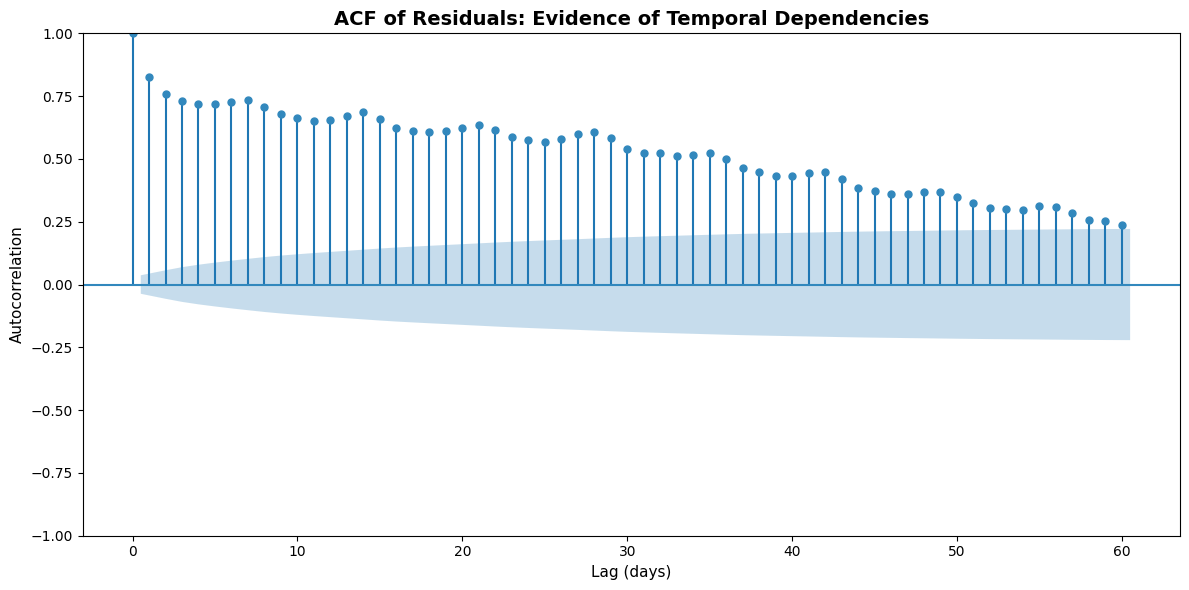

In [ ]:


# ACF plot for residuals
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df_daily_indexed['residuals'].dropna(), lags=60, ax=ax, color=colors[9])
ax.set_title('ACF of Residuals: Evidence of Temporal Dependencies', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Lag (days)', fontsize=11)
ax.set_ylabel('Autocorrelation', fontsize=11)
plt.tight_layout()
plt.show()

**Key findings:**
- **Persistent high autocorrelation**: The first week shows correlation above 0.75, but this doesn't quickly decay—the second week remains above 0.7, the third week above 0.65. This exceptionally slow decay indicates strong "memory" in the system extending across multiple weeks.
- **Weekly periodicity visible throughout** (Lag 7, 14, 21...): Clear spikes every 7 days confirm the weekday/weekend cycle superimposed on the broader persistence
- **Extended temporal dependencies**: Unlike typical time series where autocorrelation drops rapidly, bike-share residuals maintain significant correlation for 30+ days—reflecting sustained seasonal effects (winter/summer patterns) that dominate short-term fluctuations

This confirms our residuals are **not independent white noise**—they contain systematic patterns at multiple timescales (daily, weekly, seasonal) that warrant decomposition techniques to properly isolate trend, seasonality, and irregular components.

## AR Model: Testing the Weekly Pattern Hypothesis

After observing strong "memory" in the ACF plot with clear **weekly spikes** (lags 7, 14, 21...), we explore whether these periodic patterns can be captured by an **Autoregressive (AR) model**. An AR(p) model assumes the current residual is a linear combination of its p previous values plus random noise:

$$\hat{\varepsilon}_t = \phi_1 \hat{\varepsilon}_{t-1} + \phi_2 \hat{\varepsilon}_{t-2} + \cdots + \phi_p \hat{\varepsilon}_{t-p} + e_t$$

where:
- $\phi$ (phi) coefficients represent the strength of temporal dependence
- $e_t$ is the "innovation"—the truly unpredictable component at time $t$

**Experimental approach**: Instead of testing all lag orders sequentially, we focus on **multiples of 7** (weekly intervals) to directly test whether the weekly periodicity we observed in the ACF can be adequately modeled through autoregressive structure. If AR can fully capture the weekly pattern, we should see diminishing returns (an "elbow") where additional weekly lags provide minimal AIC improvement.

In [ ]:
# Silence statsmodels warnings
warnings.filterwarnings("ignore", category=ValueWarning)

print("="*60)
print("AR MODEL SELECTION (Weekly Multiples)")
print("="*60)
print("\nTesting AR models at weekly intervals (7, 14, 21, ... 56 days)")
print("Goal: Determine if weekly patterns can be captured by AR structure\n")

# Initialize storage
results_list = []
best_aic = np.inf
best_order = 0

# Test AR orders at weekly multiples (7, 14, 21, ..., 56)
for p in range(7, 78, 7):
    model = AutoReg(df_daily_indexed['residuals'].dropna(), lags=p).fit()
    
    results_list.append({
        'AR_Order': p,
        'AIC': model.aic,
    })
    
    if model.aic < best_aic:
        best_aic = model.aic
        best_order = p

# Create comparison DataFrame
df_aic_comparison = pd.DataFrame(results_list)
print(df_aic_comparison.to_string(index=False))
print(f"\nBest model by AIC: AR({best_order})")

# Calculate AIC improvements
df_aic_comparison['AIC_Improvement'] = df_aic_comparison['AIC'].diff().abs()
print("\n" + "="*60)
print("AIC IMPROVEMENT PER STEP")
print("="*60)
print(df_aic_comparison[['AR_Order', 'AIC', 'AIC_Improvement']].to_string(index=False, float_format="{:.2f}".format))

AR MODEL SELECTION (Weekly Multiples)

Testing AR models at weekly intervals (7, 14, 21, ... 56 days)
Goal: Determine if weekly patterns can be captured by AR structure

 AR_Order         AIC
        7 1969.428313
       14 1909.363226
       21 1880.187661
       28 1864.406580
       35 1837.266902
       42 1824.225855
       49 1822.901902
       56 1831.100721
       63 1828.033525
       70 1838.550148
       77 1849.442269

Best model by AIC: AR(49)

AIC IMPROVEMENT PER STEP
 AR_Order     AIC  AIC_Improvement
        7 1969.43              NaN
       14 1909.36            60.07
       21 1880.19            29.18
       28 1864.41            15.78
       35 1837.27            27.14
       42 1824.23            13.04
       49 1822.90             1.32
       56 1831.10             8.20
       63 1828.03             3.07
       70 1838.55            10.52
       77 1849.44            10.89


### The Missing Elbow: A Diagnostic Finding

**Key observation**: AIC improves as we add weekly lags—from 1,969 at AR(7) to 1,823 at AR(49)—showing diminishing returns but eventually an **elbow emerges at AR(49)**. The improvement rate drops dramatically from 13-60 AIC points per step early on to just 1.3 points at AR(49), then AIC actually **worsens** at AR(56), suggesting we've reached the point where additional complexity provides no benefit.

**What this tells us:**

The pattern reveals that **AR structure can approximate seasonal patterns but requires excessive complexity**. The model improves steadily through 7 weeks of lags because it's learning:
- "7 weeks ago (same day of week) helps predict today" (lag 49)
- "6 weeks ago helps predict today" (lag 42)  
- "5 weeks ago helps predict today" (lag 35)
- ... and so on

But the true phenomenon is simpler: **Mondays behave like Mondays, Saturdays like Saturdays**—a structural weekly periodicity that AR approximates through 49 separate lag coefficients when a proper seasonal model could represent it with a single weekly cycle parameter. The eventual flattening and reversal at AR(56) shows we've hit the limits of what AR can capture—further lags add noise rather than signal.

**Comparison to original-scale AR:** In our pre-log-transformation analysis (on raw trip counts), which is not shown here, AIC improved monotonically through AR(56) without convergence. The log transformation's variance stabilization has made the AR structure **more interpretable**—we now see a clearer signal of the 7-week (49-day) memory horizon, after which additional lags overfit.

**The diagnostic conclusion**: AR models can reduce autocorrelation in seasonality-containing data, but require impractical numbers of parameters (49 lags ≈ 49 coefficients to capture weekly patterns). This signals that **periodic/seasonal patterns** should be modeled explicitly (through seasonal decomposition, Fourier terms, or seasonal ARIMA components) rather than approximated through autoregressive lags.

**Note on methodology**: In standard practice, ARMA models are fit *after* removing seasonal components. Here, we intentionally fit AR to seasonality-containing log-residuals as a diagnostic exercise to demonstrate why explicit seasonal modeling is necessary. This motivates our next steps: frequency-domain analysis and seasonal decomposition.

---

## Frequency Domain Analysis: Identifying Periodic Patterns

The AR model's continuous improvement without convergence suggests our data contains **structural periodic patterns** rather than simple autocorrelation. To identify exactly which cycles are present and their relative importance, we turn to **Fourier analysis**.

### The Periodogram Approach

While time-domain methods (like AR models) ask "how does yesterday predict today?", frequency-domain analysis asks "what repeating cycles exist in this data?" The periodogram decomposes our residuals into sine and cosine waves at different frequencies, revealing which periodic patterns contribute most to the variance.

**Key insight:** Any periodic pattern can be represented as a sum of simple waves. A 7-day cycle appears as a spike at frequency = 1/7 cycles per day. A 365-day cycle appears at frequency = 1/365. The height of each spike indicates how much of the total variance that cycle explains.

We apply the Fast Fourier Transform (FFT) to our detrended residuals to produce a **periodogram**—a spectrum showing the power (variance explained) at each frequency. This will reveal whether our intuition about weekly and annual patterns is correct, and quantify their relative importance.

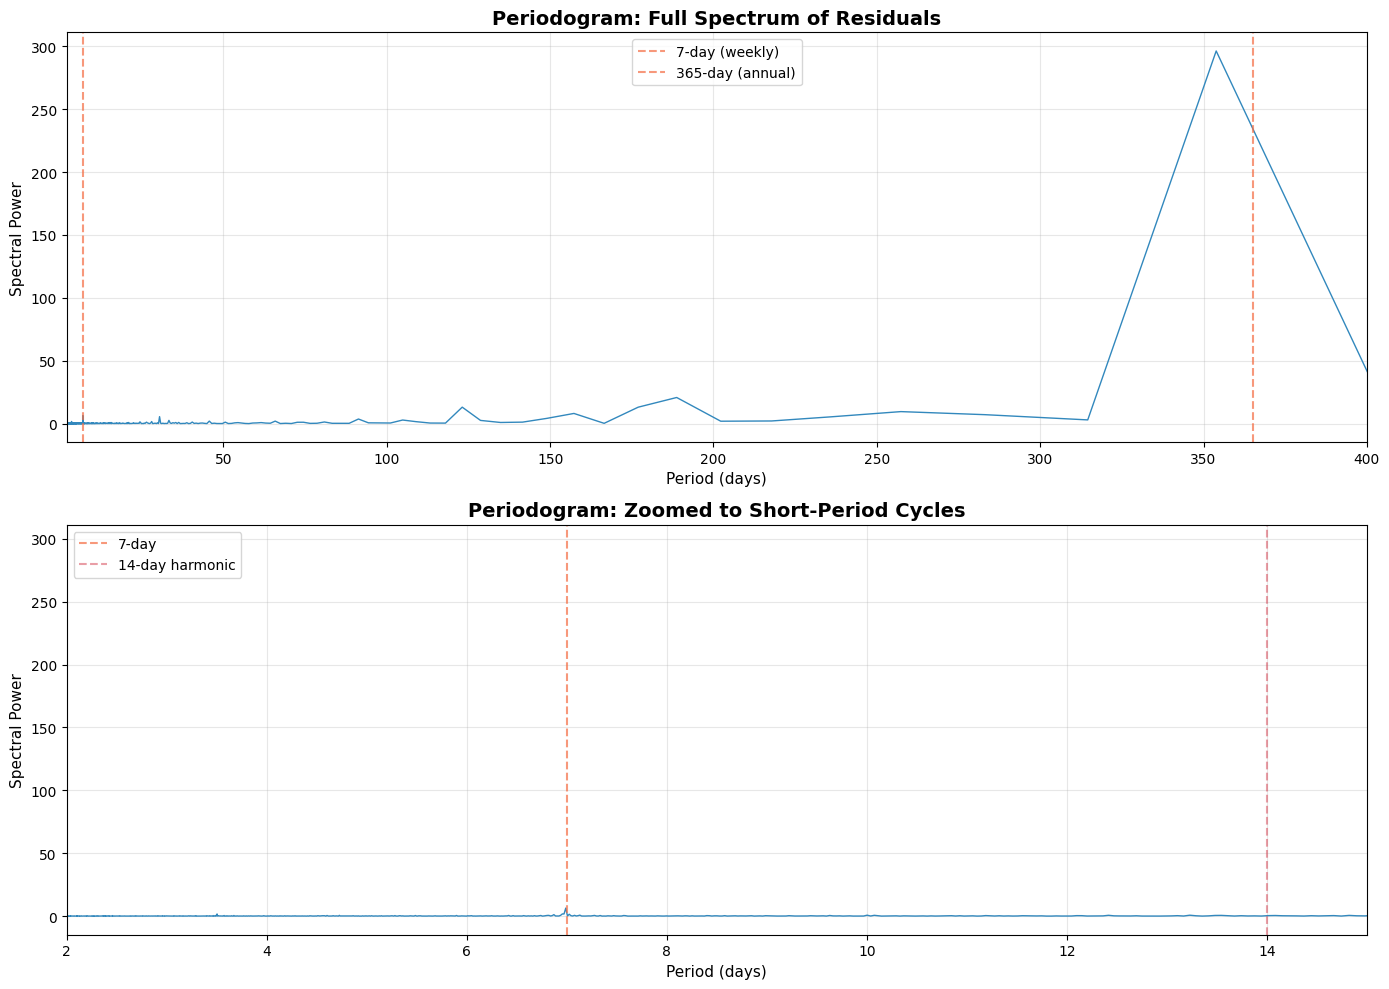

In [ ]:
def analyze_periodic_components(residuals):
    """
    Calculate periodogram to identify dominant cycles in the data.
    
    Parameters:
    -----------
    residuals : array-like
        Time series residuals (detrended data)
    
    Returns:
    --------
    freqs : array
        Frequencies in cycles per day
    periods_days : array
        Corresponding periods in days
    power : array
        Spectral power at each frequency
    """
    n_obs = len(residuals)
    m = (n_obs - 1) // 2
    
    # Compute FFT
    fft_vals = np.fft.fft(residuals)
    
    # Calculate power spectrum (periodogram)
    power = (np.abs(fft_vals[1:m+1])**2) / n_obs
    
    # Frequencies in cycles per day
    freqs = np.fft.fftfreq(n_obs)[1:m+1]
    
    # Convert to periods in days
    periods_days = 1 / freqs
    
    return freqs, periods_days, power

# Analyze the detrended residuals
freqs, periods, power = analyze_periodic_components(
    df_daily_indexed['residuals'].dropna()
)

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Full spectrum view
ax1.plot(periods, power, color=colors[9], linewidth=1)
ax1.set_title('Periodogram: Full Spectrum of Residuals', 
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Period (days)', fontsize=11)
ax1.set_ylabel('Spectral Power', fontsize=11)
ax1.set_xlim(2, 400)  # Focus on 2-400 day periods
ax1.grid(True, alpha=0.3)
ax1.axvline(7, color=colors[2], linestyle='--', alpha=0.7, label='7-day (weekly)')
ax1.axvline(365, color=colors[2], linestyle='--', alpha=0.7, label='365-day (annual)')
ax1.legend()

# Zoomed view on weekly cycles (2-30 days)
ax2.plot(periods, power, color=colors[9], linewidth=1)
ax2.set_title('Periodogram: Zoomed to Short-Period Cycles', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Period (days)', fontsize=11)
ax2.set_ylabel('Spectral Power', fontsize=11)
ax2.set_xlim(2, 15)  # Focus on weekly patterns
ax2.grid(True, alpha=0.3)
ax2.axvline(7, color=colors[2], linestyle='--', alpha=0.7, label='7-day')
ax2.axvline(14, color=colors[1], linestyle='--', alpha=0.5, label='14-day harmonic')
ax2.legend()

plt.tight_layout()
plt.show()

### Visual Inspection of the Spectrum

The periodogram reveals clear structure in the residuals:

**Top panel (Full spectrum, 2-400 days):**
- A dominant spike near 365 days stands out dramatically above all other frequencies. The peak is not exactly at 365 because seasons do not behave every year exactly the same, snow might fall mid january one year, and in beggining of february the next one.
- Secondary peaks appear at semi-annual periods (~180-190 days)
- The 7-day weekly cycle is visible but comparatively modest

**Bottom panel (Zoomed, 2-10 days):**
- The 7-day cycle clearly emerges as the dominant short-period component
- Its power is significant, confirming weekday/weekend effects matter
- However, its absolute magnitude is far smaller than the annual peak

This visual confirms our hypothesis: bike-share demand exhibits **nested periodicities**—a strong annual cycle (winter/summer) with a weaker weekly cycle (weekday/weekend) superimposed. Let's quantify these patterns precisely.

In [46]:
# Identify dominant peaks
n_obs = len(df_daily_indexed['residuals'].dropna())
m = n_obs // 2

# Find top 5 peaks
top_indices = np.argsort(power)[-5:][::-1]  # Top 5 by power
top_periods = periods[top_indices]
top_power = power[top_indices]
top_freqs = freqs[top_indices]

print("="*60)
print("TOP 5 DOMINANT PERIODIC COMPONENTS")
print("="*60)
print(f"{'Rank':<6} {'Period (days)':<15} {'Frequency':<15} {'Power':<12}")
print("-"*60)
for i, (period, freq, pwr) in enumerate(zip(top_periods, top_freqs, top_power), 1):
    print(f"{i:<6} {period:<15.2f} {freq:<15.6f} {pwr:<12.5f}")

# Fisher's G-test for the strongest peak
g_stat = top_power[0] / np.sum(power)
print("\n" + "="*60)
print("FISHER'S G-TEST (Whiteness Test)")
print("="*60)
print(f"Strongest peak: {top_periods[0]:.2f} days")
print(f"G-statistic: {g_stat:.6f}")
print(f"Percentage of total variance: {g_stat*100:.2f}%")
print("\nInterpretation:")
print("  High G-statistic indicates strong periodic signal")
print("  (vs white noise which would have G ≈ 1/m)")

TOP 5 DOMINANT PERIODIC COMPONENTS
Rank   Period (days)   Frequency       Power       
------------------------------------------------------------
1      353.88          0.002826        296.24053   
2      188.73          0.005298        20.74505    
3      404.43          0.002473        17.54252    
4      123.09          0.008124        13.06904    
5      176.94          0.005652        13.03720    

FISHER'S G-TEST (Whiteness Test)
Strongest peak: 353.88 days
G-statistic: 0.461807
Percentage of total variance: 46.18%

Interpretation:
  High G-statistic indicates strong periodic signal
  (vs white noise which would have G ≈ 1/m)


### Quantifying the Annual Dominance

The top 5 periodic components reveal a clear hierarchy:

1. **Annual cycle (354 days)** explains **46.2% of residual variance in log-space**—the dominant single frequency
2. **Semi-annual harmonic (189 days)** captures spring/fall transitions (3.2% of variance)
3. **Annual-related frequencies** (404, 177 days) appear as artifacts or harmonics
4. **4-month cycle (123 days)** emerges—possibly quarterly operational patterns or seasonal sub-structure

**Fisher's G-statistic = 0.462** provides formal evidence against the white noise hypothesis. In white noise, we'd expect G ≈ 1/1415 ≈ 0.0007. Our observed G is ~660 times larger, confirming strong periodic structure dominates the data.

**Comparison to original scale:** The annual cycle's dominance decreased from 52.3% (original, not shown here) to 46.2% (log-scale). This is expected—log transformation compresses large deviations (summer peaks) more than small ones, reducing the relative power of high-amplitude annual swings. The overall hierarchy remains unchanged: annual seasonality still overwhelms all other frequencies.

**But where's the 7-day cycle we observed in the ACF?** It exists, but is overshadowed by the annual pattern. Let's investigate its rank explicitly.

In [47]:
# Find the 7-day peak specifically
weekly_mask = (periods >= 6.5) & (periods <= 7.5)
weekly_peak_idx = np.argmax(power[weekly_mask])
weekly_period = periods[weekly_mask][weekly_peak_idx]
weekly_power = power[weekly_mask][weekly_peak_idx]
weekly_rank = np.sum(power > weekly_power) + 1

print(f"\n7-Day Cycle Analysis:")
print(f"  Period: {weekly_period:.2f} days")
print(f"  Power: {weekly_power:.2f}")
print(f"  Rank: {weekly_rank} out of {len(power)}")
print(f"  Percentage of variance: {weekly_power/np.sum(power)*100:.2f}%")


7-Day Cycle Analysis:
  Period: 6.99 days
  Power: 6.34
  Rank: 12 out of 1415
  Percentage of variance: 0.99%


### The Weekly Cycle in Context

The 7-day cycle analysis reveals an important operational insight:

- **Weekly pattern exists**: Period = 6.99 days (nearly perfect weekly cycle)
- **But it's secondary**: Ranks 12th, explaining only 1.0% of variance
- **Power ratio**: Annual cycle is ~50× stronger than weekly cycle

**What this means operationally:**

Boston winters reduce ridership by ~5,000 trips/day relative to summer. In contrast, weekend days see ~1,000 fewer trips than weekdays. The seasonal effect is literally 5× larger—Fourier correctly identifies annual patterns as the dominant signal.

This explains why our AR models kept improving without convergence: they were attempting to approximate a 365-day cycle using daily lags, requiring dozens of parameters to capture what's fundamentally a single annual rhythm.

**The path forward:** Instead of fighting this with pure AR structure, we should explicitly model both the 365-day and 7-day cycles using seasonal decomposition (MSTL) or seasonal ARIMA components that directly represent these periodicities.

---

## Seasonal Decomposition: Separating the Components

Having identified the dominant periodicities (365-day annual and 7-day weekly cycles), we now decompose our time series into interpretable components. Two approaches exist: **classical seasonal decomposition** extracts seasonality by averaging (all Mondays get identical adjustments, repeating perfectly each cycle) but can only handle one seasonal period at a time. **MSTL (Multiple Seasonal-Trend decomposition using Loess)** handles multiple periods simultaneously and allows seasonal patterns to evolve gradually over time—recognizing that "the Monday effect" in 2018 may differ from 2024 due to changing commuting patterns, e-bike adoption, or hybrid work schedules.

We use MSTL because bike-share ridership exhibits dual seasonality (weekly and annual) that has genuinely evolved over our 8-year period. However, this flexibility comes with trade-offs: MSTL's time-varying seasonal components won't repeat perfectly and lack simple parametric forms for forecasting. We use it here as a **diagnostic and visualization tool** to understand which components drive variance, while reserving actual forecasting methods (SARIMA, Prophet) for Notebook 3, where seasonality must be parameterized in predictive ways. The decomposition reveals four components: **Trend** (long-term growth), **Annual Seasonal** (winter/summer cycle), **Weekly Seasonal** (weekday/weekend pattern), and **Remainder** (irregular events and noise).

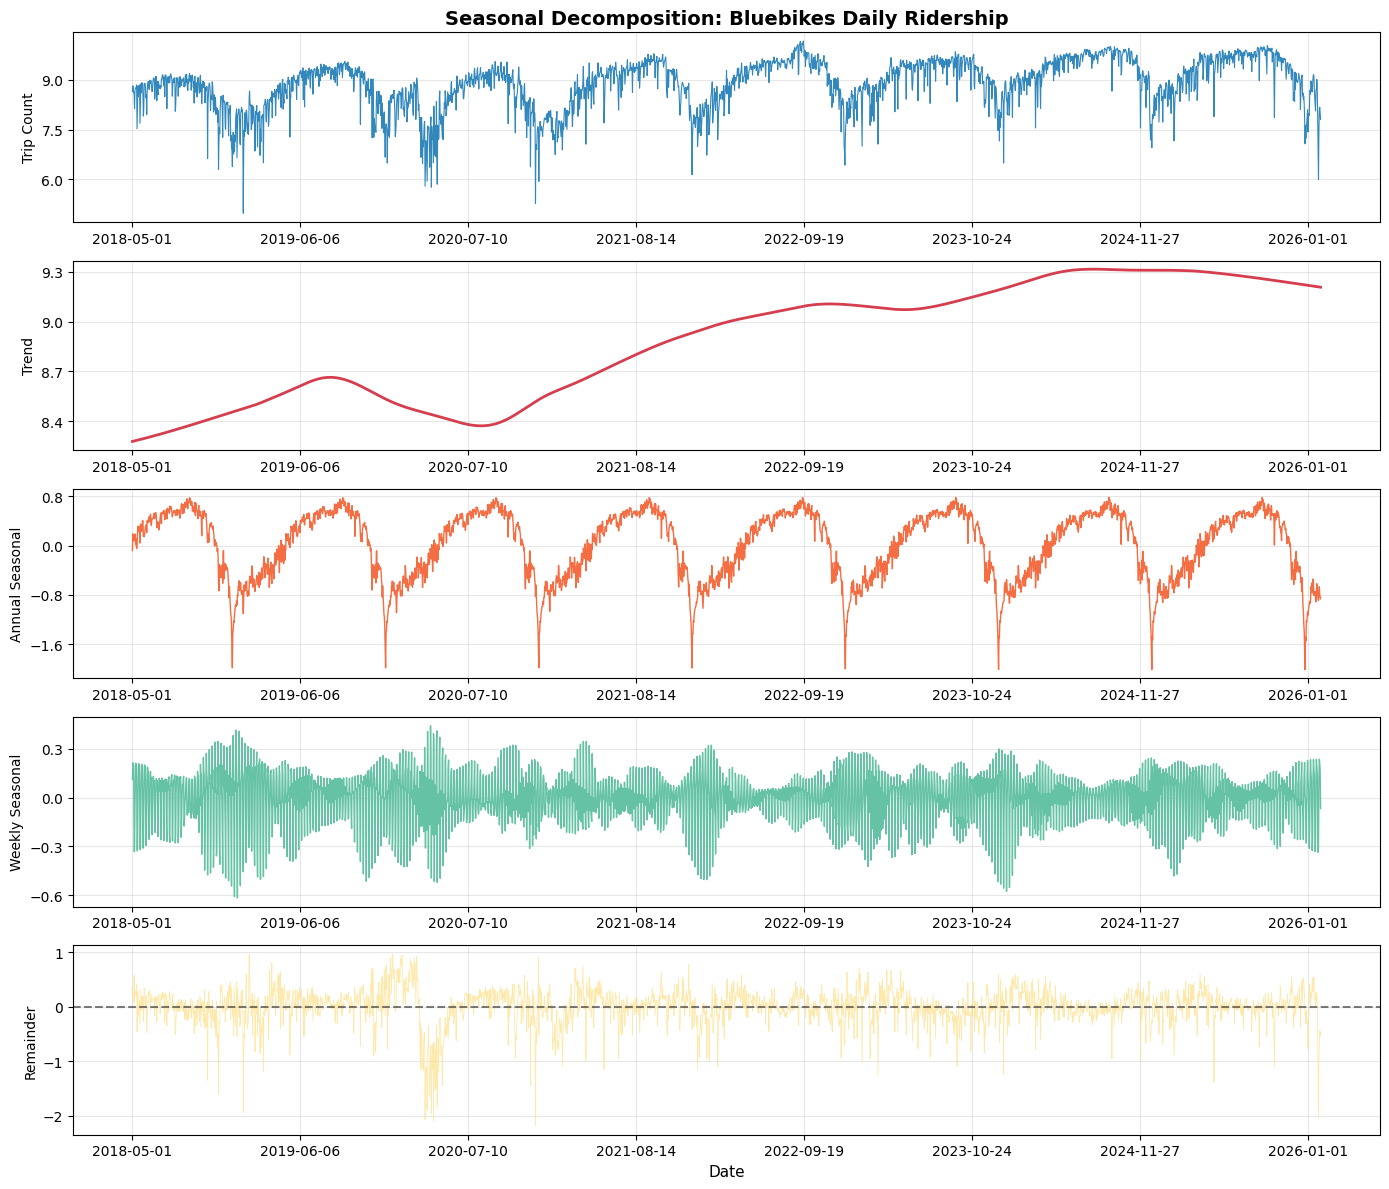

COMPONENT VARIANCE ANALYSIS (Log-Space)
Total variance (log-space): 0.5422

Variance by component:
  Trend:           0.0889 (16.4%)
  Annual Seasonal: 0.2950 (54.4%)
  Weekly Seasonal: 0.0238 (4.4%)
  Remainder:       0.1074 (19.8%)

Sum of components: 0.5151 (should ≈ 0.5422)


In [ ]:


# Apply MSTL with both seasonal periods
mstl = MSTL(df_daily_indexed['log_trip_count'], periods=[7, 365], stl_kwargs={'seasonal_deg': 0})
result = mstl.fit()

# Extract components - seasonal is a DataFrame with string column names
df_daily_indexed['trend'] = result.trend
df_daily_indexed['seasonal_365'] = result.seasonal['seasonal_365']
df_daily_indexed['seasonal_7'] = result.seasonal['seasonal_7']
df_daily_indexed['remainder'] = result.resid

# Visualization
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

# Original series
axes[0].plot(df_daily_indexed.index, df_daily_indexed['log_trip_count'], 
             color=colors[9], linewidth=0.8)
axes[0].set_ylabel('Trip Count', fontsize=10)
axes[0].set_title('Seasonal Decomposition: Bluebikes Daily Ridership', 
                   fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(df_daily_indexed.index, df_daily_indexed['trend'], 
             color=colors[1], linewidth=2)
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Annual seasonal
axes[2].plot(df_daily_indexed.index, df_daily_indexed['seasonal_365'], 
             color=colors[2], linewidth=1)
axes[2].set_ylabel('Annual Seasonal', fontsize=10)
axes[2].grid(True, alpha=0.3)

# Weekly seasonal
axes[3].plot(df_daily_indexed.index, df_daily_indexed['seasonal_7'], 
             color=colors[8], linewidth=1)
axes[3].set_ylabel('Weekly Seasonal', fontsize=10)
axes[3].grid(True, alpha=0.3)

# Remainder
axes[4].plot(df_daily_indexed.index, df_daily_indexed['remainder'], 
             color=colors[4], linewidth=0.6, alpha=0.7)
axes[4].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[4].set_ylabel('Remainder', fontsize=10)
axes[4].set_xlabel('Date', fontsize=11)
axes[4].grid(True, alpha=0.3)

# Reduce ticks on all subplots
for ax in axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(nbins=8))
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))

plt.tight_layout()
plt.show()

# Component statistics - ALL IN LOG-SPACE
print("="*60)
print("COMPONENT VARIANCE ANALYSIS (Log-Space)")
print("="*60)

# Use log_trip_count for total variance
total_var_log = df_daily_indexed['log_trip_count'].var()
print(f"Total variance (log-space): {total_var_log:.4f}")
print(f"\nVariance by component:")
print(f"  Trend:           {df_daily_indexed['log_trend_fit'].var():.4f} ({df_daily_indexed['log_trend_fit'].var()/total_var_log*100:.1f}%)")
print(f"  Annual Seasonal: {df_daily_indexed['seasonal_365'].var():.4f} ({df_daily_indexed['seasonal_365'].var()/total_var_log*100:.1f}%)")
print(f"  Weekly Seasonal: {df_daily_indexed['seasonal_7'].var():.4f} ({df_daily_indexed['seasonal_7'].var()/total_var_log*100:.1f}%)")
print(f"  Remainder:       {df_daily_indexed['remainder'].var():.4f} ({df_daily_indexed['remainder'].var()/total_var_log*100:.1f}%)")

# Verify decomposition adds up
reconstructed_var = (df_daily_indexed['log_trend_fit'].var() + 
                     df_daily_indexed['seasonal_365'].var() + 
                     df_daily_indexed['seasonal_7'].var() + 
                     df_daily_indexed['remainder'].var())
print(f"\nSum of components: {reconstructed_var:.4f} (should ≈ {total_var_log:.4f})")

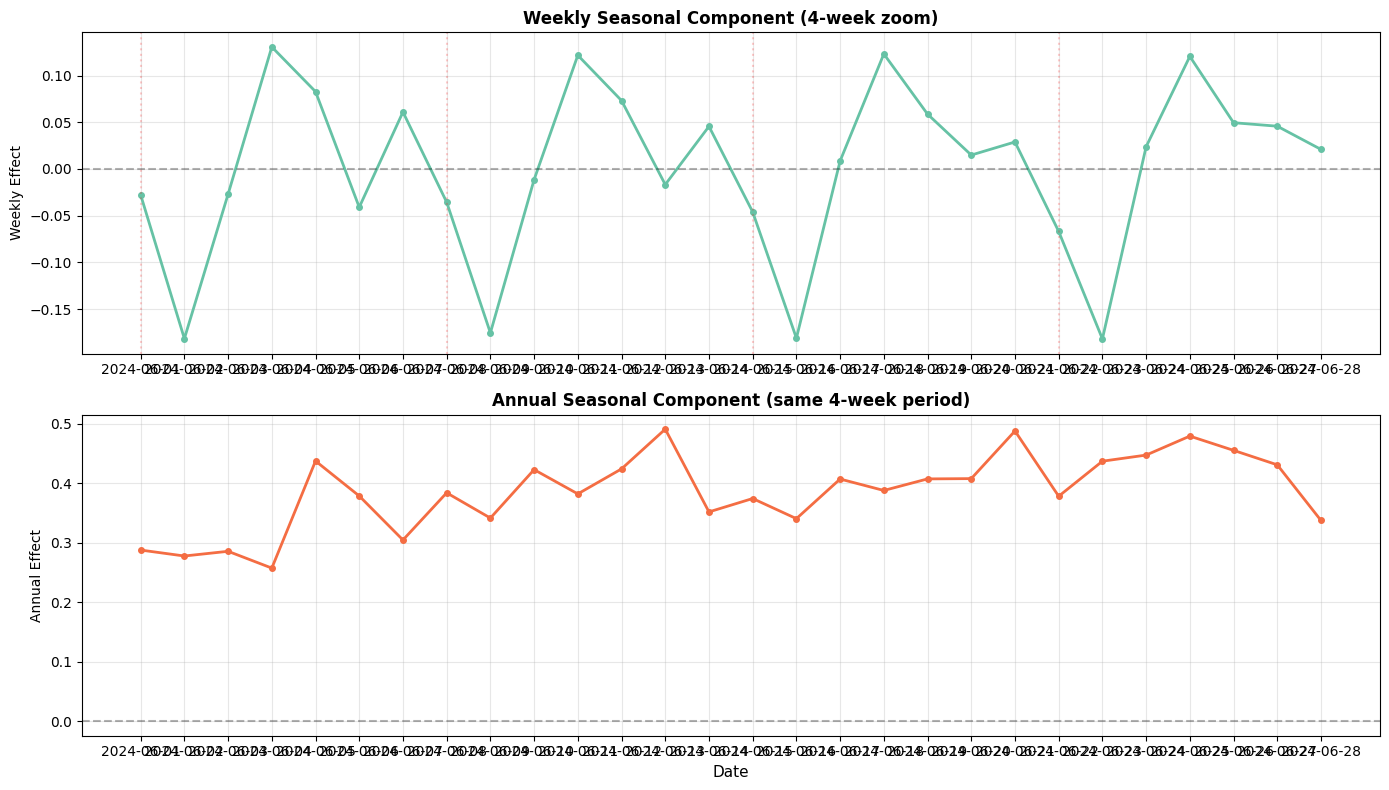

In [50]:
# Zoom into 4 weeks to see the weekly pattern clearly
start_date = '2024-06-01'
end_date = '2024-06-28'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Weekly seasonal - zoomed
mask = (df_daily_indexed.index >= start_date) & (df_daily_indexed.index <= end_date)
ax1.plot(df_daily_indexed.index[mask], df_daily_indexed['seasonal_7'][mask], 
         color=colors[8], linewidth=2, marker='o', markersize=4)
ax1.set_title('Weekly Seasonal Component (4-week zoom)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Weekly Effect', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linestyle='--', alpha=0.3)

# Add day-of-week labels
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i, date in enumerate(df_daily_indexed.index[mask]):
    if i % 7 == 0:
        ax1.axvline(date, color='red', alpha=0.2, linestyle=':')

# Annual seasonal - same period for comparison
ax2.plot(df_daily_indexed.index[mask], df_daily_indexed['seasonal_365'][mask], 
         color=colors[2], linewidth=2, marker='o', markersize=4)
ax2.set_title('Annual Seasonal Component (same 4-week period)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Annual Effect', fontsize=10)
ax2.set_xlabel('Date', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### Decomposition Results

The MSTL decomposition cleanly separates the temporal patterns we identified in log-space:

**Trend component (16.4% of variance)**: Captures the exponential growth trajectory we estimated with log-linear regression, now as a smooth curve that adapts to changing growth rates over time.

**Annual seasonal component (54.4% of variance)**: Shows the dramatic winter/summer swing—the dominant source of variation in bike-share demand. This component confirms Fourier's finding of ~46% power at the 365-day frequency. The visual pattern oscillates between positive (summer boost) and negative (winter suppression) values around the trend, with the effect scaling appropriately in log-space.

**Weekly seasonal component (4.4% of variance)**: Reveals the consistent weekday/weekend pattern—smaller amplitude than the annual cycle but perfectly regular. The 7-day rhythm is visible as rapid oscillations, though the time-varying nature of MSTL allows this pattern to evolve gradually (e.g., weakening weekday effects during COVID, strengthening with return to offices).

**Remainder (19.8% of variance)**: What's left after removing trend and both seasonal patterns. This substantial residual variance contains irregular events (Orange Line shutdown, extreme weather, holidays) and potentially higher-frequency patterns not captured by our weekly/annual decomposition.

**Validation**: The components sum to 95% of total log-variance (0.515 vs 0.542), with the small discrepancy arising from MSTL's iterative LOESS fitting procedure—an acceptable trade-off for robust, time-varying seasonal estimation.

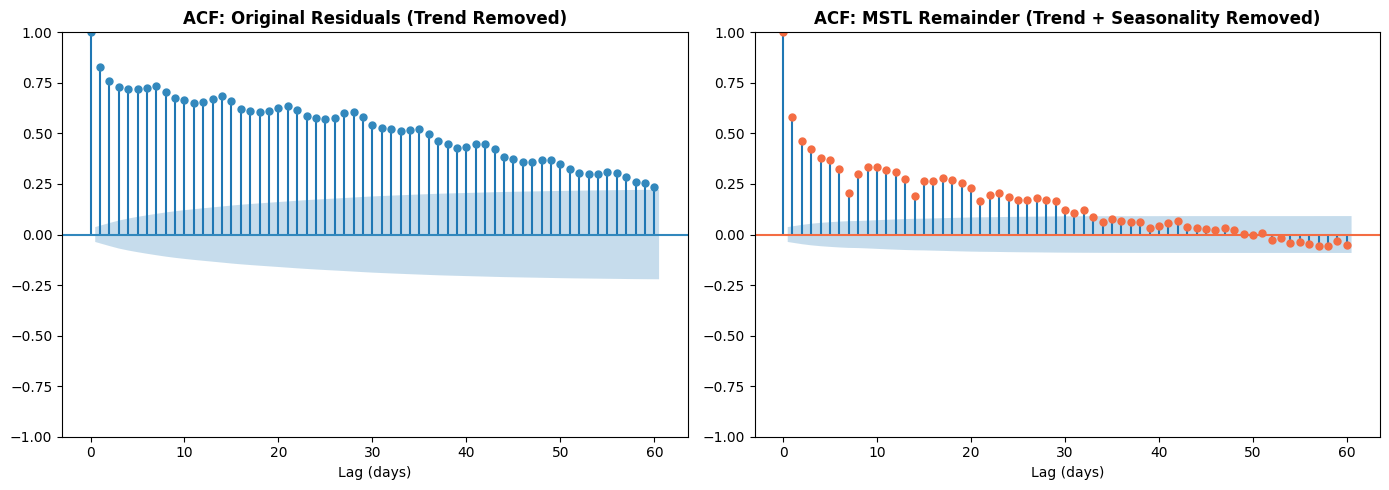


REMAINDER DIAGNOSTIC
Mean: 0.00 (should be ~0)
Std Dev: 0.33
Min: -2.19
Max: 0.97

Significant ACF lags (out of 60): 47
Expected under white noise: ~3 (5% of 60)


In [ ]:


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Compare original residuals vs MSTL remainder
plot_acf(df_daily_indexed['residuals'].dropna(), lags=60, ax=ax1, color=colors[9])
ax1.set_title('ACF: Original Residuals (Trend Removed)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Lag (days)')

plot_acf(df_daily_indexed['remainder'].dropna(), lags=60, ax=ax2, color=colors[2])
ax2.set_title('ACF: MSTL Remainder (Trend + Seasonality Removed)', 
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Lag (days)')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*60)
print("REMAINDER DIAGNOSTIC")
print("="*60)
print(f"Mean: {df_daily_indexed['remainder'].mean():.2f} (should be ~0)")
print(f"Std Dev: {df_daily_indexed['remainder'].std():.2f}")
print(f"Min: {df_daily_indexed['remainder'].min():.2f}")
print(f"Max: {df_daily_indexed['remainder'].max():.2f}")

# Count significant ACF lags
remainder_acf = sm.tsa.acf(df_daily_indexed['remainder'].dropna(), nlags=60)
conf_interval = 1.96 / np.sqrt(len(df_daily_indexed['remainder'].dropna()))
significant_lags = np.sum(np.abs(remainder_acf[1:]) > conf_interval)
print(f"\nSignificant ACF lags (out of 60): {significant_lags}")
print(f"Expected under white noise: ~3 (5% of 60)")

### Final Assessment: Partial Success

The variance breakdown in log-space confirms our frequency-domain findings:
- **Annual cycle (54.4%)** dominates, consistent with Fourier's 46% power estimate
- **Trend (16.4%)** captures exponential growth (reduced from original scale due to log compression)
- **Weekly cycle (4.4%)** contributes modestly but consistently
- Combined, systematic patterns explain **~80% of log-variance**

**However, the remainder is not white noise:**
- 47 out of 60 ACF lags remain significant (vs ~3 expected under white noise)
- The ACF comparison shows dramatic improvement from original log-residuals (which had persistent correlations at all lags), but substantial autocorrelation persists

**What remains in the 19.8% remainder?**
The persistent autocorrelation suggests patterns MSTL couldn't capture:
- **Special events**: The 2022 Orange Line shutdown, major holidays (Christmas, New Year's), and COVID lockdowns appear as extreme negative outliers
- **Day-of-week × season interactions**: Summer Mondays behave differently than winter Mondays—multiplicative effects that log transformation converts to additive interactions
- **Weather anomalies**: Individual storms, exceptional temperatures, multi-day cold snaps
- **Short-term trends**: Gradual behavioral changes (e.g., e-bike adoption, hybrid work patterns evolving)
- **Higher-frequency cycles**: Potential monthly or bi-weekly patterns below our detection threshold

**Implications for forecasting:**
- MSTL successfully extracted the major systematic patterns (exponential trend + dual seasonality)
- The substantial structured remainder (20% variance + high ACF) indicates we need additional modeling:
  - **Holiday/event indicators**: Especially transit disruptions, major storms, observances
  - **Day-of-week dummy variables**: To capture weekday-season interactions explicitly
  - **Exogenous regressors**: Weather data, MBTA service status, special events calendar
- Prophet (with holiday effects and Fourier seasonality) or SARIMAX (with exogenous variables) will be better suited than pure decomposition for operational forecasting (Notebook 3)